## EXPERIMENT NOTES

The dataset is of student performance in Portuguese schools.   Grades are ranged from 0-20 with 10 (9.5 rounding up to 10) being a passing grade.  

The instructions were somewhat amibigious as the dataset can be used for either  classification or regression problem.    

For regression, I chose  G3 (Final grade) are my Y/target column.

For classification, I used G3 to form 3 categories ( Fail,  Pass, Top 30 Percent of students ).	

As the dataset notes, inclusion of G1/G2 has a material impact on performance. 

Prior grades (e.g. G1/G2)  are highly predictive of final grade ( G3).   If G2/G3 are chosen, the model will predict more accurately but we learn less about how other factors can influence student performance. 

Given the focus of the homework was on hyper-parameters, I expanded the scope to also include feature selection technique as a hyper parameter as well — Random Forest, Linear SVM, RFE, RFECV were all tested.   Please see hyper parameter summary below.

#### Final hyperparameters
-G1/G2 inclusion as features.  G1/G2 can be excluded to show the predictive impact of non-academic features.

-Features ( Random Forest, Linear SVM, RFE, RFECV)

-Model (e.g. C, Kernel for SV and n_estimators and max_depth for Random Forest)

### Conclusions: Classification

The various feature selection techniques produced a broad range of outcomes.  RF_SVM produced 3 features while RFECV produced 23 with the other two techniques in the middle.   

The best classifier on test data was an SVM trained on only 3 features (G1, G2, Num_failures).. On the flip side, RFECV selected 23 variables when coupled with a Random Forest Classifier performed the best on the train achieving 96% accuracy but fails to generalize on test data.

As the dataset notes, given the predictive power of G1/G2, when included, the other variables are largely ignored so don’t learn much about them.

When we remove G1/G2, the feature selection techniques pick up a lot more variables ranging from 15-29.  We are not able to get the same performance but are able to beat random (60% accuracy) using 15 features.

### Conclusions: Regression

Regression showed a very similar pattern — with G1/G2 included, we able to achieve an R2 of 92.7 using a RandomForest regressor built using 2 features (G2 and num_absenses).

With G1/G2 removed, it the feature selection algorithms picked up a larger number of features but was much more difficult to build a predictive regression model.    The best model (MSE 3.6, RS .36) was built using a SVR and 13 features.   Also, support vector machines tended to generalize better — Random forests dominated the R2/MSE of the training sets but SVM tended to outperform on train.


##### RandomSearchCV 

This function is very similar to GridSearchCV.   This is a better appraoch when the testing all hyperparameter combos is computationally expensive.   In RandomSearchCV, the number of iterations (e.g amount of compute) is pre-specified and the algorithm samples as many combinations within that budget.
***

#### (Full Results at bottom of notebook)

***


Instructions: Have all the code for all the questions in one Jupyter notebook and upload the file at the time of submission. I will only consider this file format for grading. So, after you uploaded the file, check the file extension and if it is not an ipynb, then upload the right file.

Consider student_performance dataset.

Details about the dataset:

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features) and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd-period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

Do the following:

1) Find out the features that are important.

2) Convert categorical features to numeric.

2) Use important features to build the following:

a) Apply SVM along with GridSearchCV to determine the best parameters 
for kernel and C. Use the best parameters from the search and build an SVC model and compute confusion matrix, classification report and accuracy.

b) Likewise, use GridSearchCV to find the best number of trees for Random Forest and then build Random Forest Classifier and compute confusion matrix, classification report and accuracy.

Also read about RandomSearchCV.  And explain the difference between RandomSearchCV and GridSearchCV.

In [1]:

"""
This code imports the necessary libraries for the implementation of the machine learning models. 
It also sets the display options for pandas dataframes. 
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing

from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC   
from sklearn.svm import LinearSVR

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV


from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score




pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [2]:
"""
This code sets the value of the variable 'use_categorical_classifier' to True. 
This variable is used to determine whether to use categorical classification or regression
If 'use_categorical_classifier' is True, categorical classification is used. 
If 'use_categorical_classifier' is False, regression classification is used.
"""
use_categorical_classifier = False


"""
Include G1/G2 in the training set as potential features or not.  This has a material impact on feature
selection & also model performance.  

"""

include_g1g2 = True

rand_state = np.random.RandomState(seed=42)
#RandomState(MT19937) at 0x171736240
rand_state

RandomState(MT19937) at 0x172B8D240

In [3]:
"""
This code reads the student-performance.csv file and loads it into a pandas dataframe called sp_df. 
It then displays the first 10 rows of the dataframe using the head() method.
"""

sp_df = pd.read_csv('student-performance.csv')
sp_df.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13
5,GP,M,16,U,LE3,T,4,3,services,other,reputation,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,4,2,1,2,5,6,12,12,13
6,GP,M,16,U,LE3,T,2,2,other,other,home,mother,1,2,0,no,no,no,no,yes,yes,yes,no,4,4,4,1,1,3,0,13,12,13
7,GP,F,17,U,GT3,A,4,4,other,teacher,home,mother,2,2,0,yes,yes,no,no,yes,yes,no,no,4,1,4,1,1,1,2,10,13,13
8,GP,M,15,U,LE3,A,3,2,services,other,home,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,2,2,1,1,1,0,15,16,17
9,GP,M,15,U,GT3,T,3,4,other,other,home,mother,1,2,0,no,yes,no,yes,yes,yes,yes,no,5,5,1,1,1,5,0,12,12,13


In [4]:
sp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [5]:
sp_df.describe( include = 'all' )

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649,649,649.000000,649,649,649,649.000000,649.000000,649,649,649,649,649.000000,649.000000,649.000000,649,649,649,649,649,649,649,649,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,4,3,NaN,NaN,NaN,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,course,mother,NaN,NaN,NaN,no,yes,no,no,yes,yes,yes,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,423,383,NaN,452,457,569,NaN,NaN,258,367,285,455,NaN,NaN,NaN,581,398,610,334,521,580,498,410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.744222,NaN,NaN,NaN,2.514638,2.306626,NaN,NaN,NaN,NaN,1.568567,1.930663,0.221880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,NaN,NaN,1.218138,NaN,NaN,NaN,1.134552,1.099931,NaN,NaN,NaN,NaN,0.748660,0.829510,0.593235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,NaN,NaN,1.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,NaN,NaN,2.000000,2.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000


In [6]:

"""
This code creates two new TARGET/Y columns in the sp_df dataframe: 'y_grade_cat' and 'y_netgrade'.

y_grade_cat: This column is used for classificaiton mode 
'y_grade_cat' column is created based on the final grade 'G3' of the students. 
9.5 is the minimum passing grade in the Portuguese education system.  We seperate grades into three categories:
Fai (<9.5), Pass (>= 9.5), and (code spec) Top 30%.

y_netgrade: This column is used for regression mode
'y_netgrade' is the student's final grade 'G3'
"""
bottom_30, top_30 = sp_df['G3'].quantile([.33, 0.7])
sp_df['y_grade_cat'] = sp_df['G3'].apply(lambda x: 0 if x <= 9.5 else 2 if x >= top_30 else 1)
                                         
Y_labels = ['Fail','Pass','Top 30%']


#sp_df["y_netgrade"] =   sp_df[['G1', 'G2', 'G3']].mean(axis='columns')
if(include_g1g2):
    sp_df["y_netgrade"] = sp_df["G3"]
else:
    sp_df["y_netgrade"] = sp_df[['G1', 'G2', 'G3']].mean(axis='columns')

if(include_g1g2):
    sp_df.drop(["G3"], axis=1, inplace=True)
else:
    sp_df.drop(["G3","G1","G2"], axis=1, inplace=True)



In [7]:
#
# Create Y and X for the model
#

if(use_categorical_classifier):
    Y = sp_df["y_grade_cat"].copy()
else:
    Y = sp_df["y_netgrade"].copy()
    
X = sp_df.drop(["y_netgrade", "y_grade_cat" ], axis=1).copy()

In [8]:
#
# Setup data for feature selection
#
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns


preprocessor = ColumnTransformer(
               transformers=[
               ('num', MinMaxScaler(), numerical_features),
               ('cat', OrdinalEncoder(), categorical_features)])
               #('cat', OrdinalEncoder(drop='if_binary'), categorical_features)])

X_transformed = preprocessor.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

X_transformed.head()

,num__age,num__Medu,num__Fedu,num__traveltime,num__studytime,num__failures,num__famrel,num__freetime,num__goout,num__Dalc,num__Walc,num__health,num__absences,num__G1,num__G2,cat__school,cat__sex,cat__address,cat__famsize,cat__Pstatus,cat__Mjob,cat__Fjob,cat__reason,cat__guardian,cat__schoolsup,cat__famsup,cat__paid,cat__activities,cat__nursery,cat__higher,cat__internet,cat__romantic
0,0.428571,1.00,1.00,0.333333,0.333333,0.0,0.75,0.50,0.75,0.00,0.00,0.5,0.1250,0.000000,0.578947,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.285714,0.25,0.25,0.000000,0.333333,0.0,1.00,0.50,0.50,0.00,0.00,0.5,0.0625,0.473684,0.578947,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.000000,0.25,0.25,0.000000,0.333333,0.0,0.75,0.50,0.25,0.25,0.50,0.5,0.1875,0.631579,0.684211,0.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
3,0.000000,1.00,0.50,0.000000,0.666667,0.0,0.50,0.25,0.25,0.00,0.00,1.0,0.0000,0.736842,0.736842,0.0,0.0,1.0,0.0,1.0,1.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,0.142857,0.75,0.75,0.000000,0.333333,0.0,0.75,0.50,0.25,0.00,0.25,1.0,0.0000,0.578947,0.684211,0.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [9]:
# Show correlations between features and target variable

X_transformed.corrwith( Y ).abs().sort_values(ascending=False)

num__G2            0.918548
num__G1            0.826387
num__failures      0.393316
cat__higher        0.332172
cat__school        0.284294
num__studytime     0.249789
num__Medu          0.240151
num__Fedu          0.211800
num__Dalc          0.204719
num__Walc          0.176619
cat__address       0.167637
cat__internet      0.150025
cat__Mjob          0.148252
cat__sex           0.129077
num__traveltime    0.127173
cat__reason        0.124969
num__freetime      0.122705
num__age           0.106505
num__health        0.098851
num__absences      0.091379
cat__romantic      0.090583
num__goout         0.087641
cat__guardian      0.079609
cat__schoolsup     0.066405
num__famrel        0.063361
cat__activities    0.059791
cat__famsup        0.059206
cat__paid          0.054898
cat__Fjob          0.052953
cat__famsize       0.045016
cat__nursery       0.028752
cat__Pstatus       0.000754
dtype: float64

In [10]:
"""
This code initializes an empty dictionary called 'feature_selected'. 
This dictionary will be used to store the selected features after feature selection.
"""

feature_selected = {}

"""
Code to split the data into training and testing sets for feature selection.
"""

X_train,X_test,y_train, y_test = train_test_split(X_transformed,Y, test_size=0.25,random_state=rand_state)


In [11]:

"""
This code performs feature selection using the Random Forest algorithm with SelectFromModel method.
The algorithm is used for classification if 'use_categorical_classifier' is True, and regression if it is False.
The selected features are stored in a dictionary called 'feature_selected'.
"""
model = RandomForestClassifier(n_estimators = 100, random_state=rand_state) if use_categorical_classifier else RandomForestRegressor(n_estimators = 100, random_state=rand_state)

sel = SelectFromModel(model)
sel.fit(X_train, y_train)

x = sel.get_support()
col_important = X_transformed.columns[x]
col_important =   [x for x in col_important]

feature_selected['RF_SFM'] = col_important
                 

print("Important features RF_SFM: " , col_important)



Important features RF_SFM:  ['num__absences', 'num__G2']


In [12]:
"""
This code performs feature selection using the Linear Support Vector Machine algorithm with SelectFromModel method.
The algorithm is used for classification if 'use_categorical_classifier' is True, and regression if it is False.
The selected features are stored in a dictionary called 'feature_selected'.
"""

model = LinearSVC(C=0.01, dual=False, loss='squared_hinge', random_state=rand_state) if use_categorical_classifier else LinearSVR(C=0.01, dual=False, loss='squared_epsilon_insensitive', random_state=rand_state)

sel = SelectFromModel(model)
sel.fit(X_train, y_train)

x = sel.get_support()

x = sel.get_support()
col_important = X_transformed.columns[x]
col_important =   [x for x in col_important]

feature_selected['LSV_SFM'] = col_important
                 

print("Important features LSV_SFM: " , col_important)

Important features LSV_SFM:  ['num__Fedu', 'num__studytime', 'num__failures', 'num__famrel', 'num__G1', 'num__G2', 'cat__address', 'cat__Pstatus', 'cat__higher']


In [13]:

# This code block performs feature selection using the Recursive Feature Elimination (RFE) method with Random Forest algorithm.
# The algorithm is used for classification if 'use_categorical_classifier' is True, and regression if it is False.
# The selected features are stored in a dictionary called 'feature_selected'.



estimator = RandomForestClassifier(n_estimators = 100, random_state=rand_state) if use_categorical_classifier else RandomForestRegressor(n_estimators = 100, random_state=rand_state)

selector = RFE(estimator, step=1)

selector = selector.fit(X_train, y_train)

best_cols_selected = X_transformed.columns[selector.support_]
best_cols_selected = [x for x in best_cols_selected]

feature_selected["RFE"] = best_cols_selected

print("Best columns selected: ", best_cols_selected)


Best columns selected:  ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__Mjob', 'cat__famsup']


In [14]:
"""
This code block performs feature selection using the Recursive Feature Elimination with Cross-Validation (RFECV) method with Random Forest algorithm.
The algorithm is used for classification if 'use_categorical_classifier' is True, and regression if it is False.
The selected features are stored in a dictionary called 'feature_selected'.
"""


estimator = RandomForestClassifier(n_estimators = 100, random_state=rand_state) if use_categorical_classifier else RandomForestRegressor(n_estimators = 100, random_state=rand_state)

selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X_train, y_train)


best_cols_selected = X_transformed.columns[selector.support_]
best_cols_selected = [x for x in best_cols_selected]

feature_selected["RFECV"] = best_cols_selected

print("Best columns selected: ", best_cols_selected)



Best columns selected:  ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__famsup', 'cat__paid', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']


In [15]:
#
# Print the feature selected by each method
#
for item, key in feature_selected.items():
    print(item, len(key), key)

RF_SFM 2 ['num__absences', 'num__G2']
LSV_SFM 9 ['num__Fedu', 'num__studytime', 'num__failures', 'num__famrel', 'num__G1', 'num__G2', 'cat__address', 'cat__Pstatus', 'cat__higher']
RFE 16 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__Mjob', 'cat__famsup']
RFECV 31 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__famsup', 'cat__paid', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']


Testing Model Name: **SVR** with features: RF_SFM
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best C: 14 and Best Kernel: linear
The delta between the two MSE is: 59.47% 
r-squared for the test data: 0.910
r-squared for the train data: 0.823


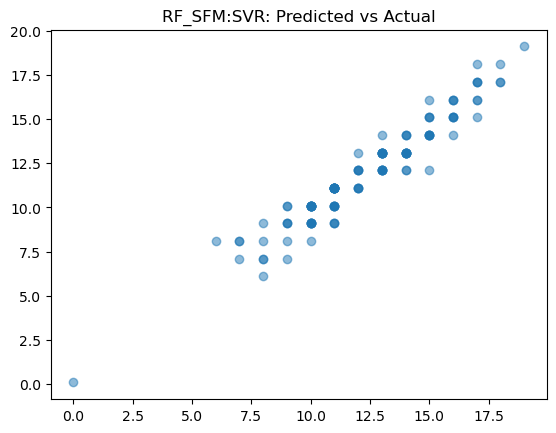




Testing Model Name: **RandomForestRegressor** with features: RF_SFM
Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best n_estimators: 30 and Best max_depth: 4
The delta between the two MSE is: 61.08% 
r-squared for the test data: 0.930
r-squared for the train data: 0.858


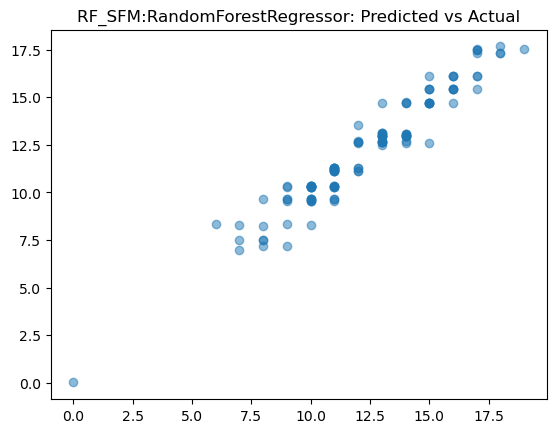




Testing Model Name: **SVR** with features: LSV_SFM
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best C: 30 and Best Kernel: linear
The delta between the two MSE is: 18.03% 
r-squared for the test data: 0.869
r-squared for the train data: 0.838


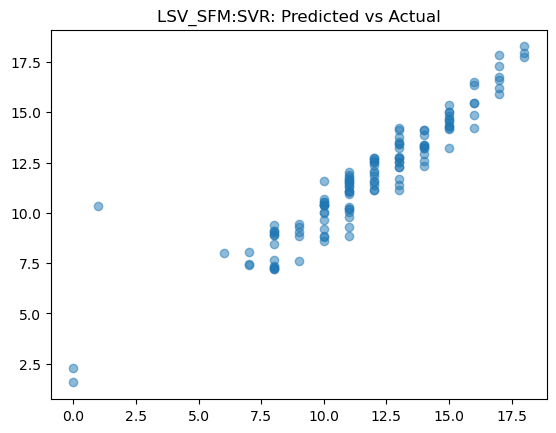




Testing Model Name: **RandomForestRegressor** with features: LSV_SFM
Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best n_estimators: 30 and Best max_depth: 4
The delta between the two MSE is: 53.90% 
r-squared for the test data: 0.827
r-squared for the train data: 0.886


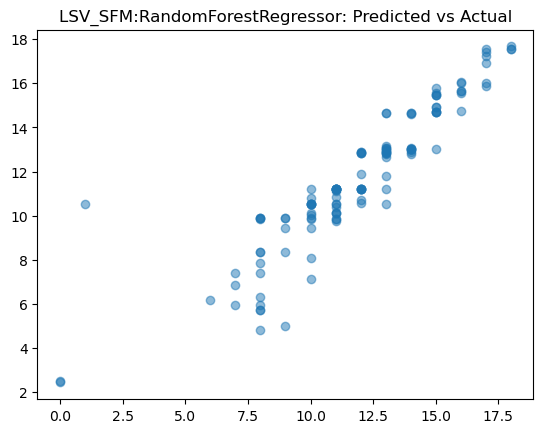




Testing Model Name: **SVR** with features: RFE
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best C: 35 and Best Kernel: linear
The delta between the two MSE is: 61.66% 
r-squared for the test data: 0.927
r-squared for the train data: 0.821


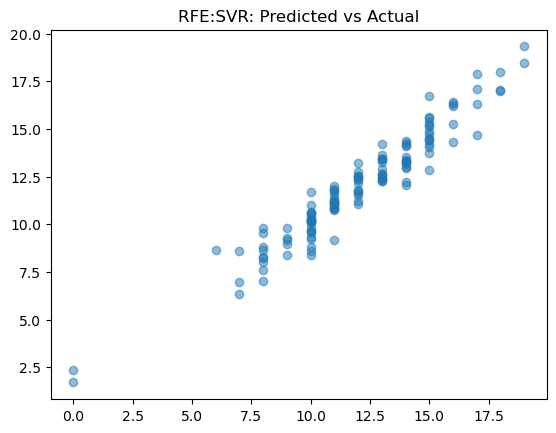




Testing Model Name: **RandomForestRegressor** with features: RFE
Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best n_estimators: 70 and Best max_depth: 5
The delta between the two MSE is: 30.21% 
r-squared for the test data: 0.887
r-squared for the train data: 0.919


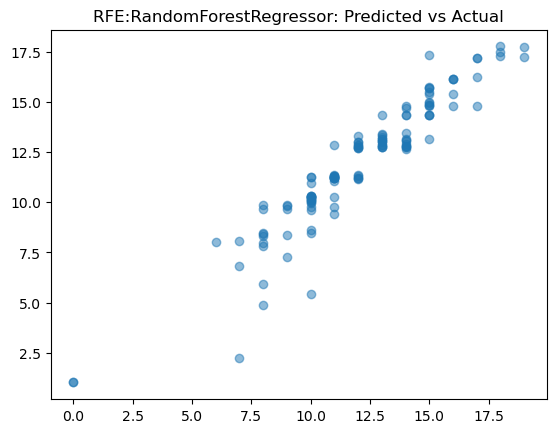




Testing Model Name: **SVR** with features: RFECV
Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best C: 20 and Best Kernel: linear
The delta between the two MSE is: 58.08% 
r-squared for the test data: 0.926
r-squared for the train data: 0.826


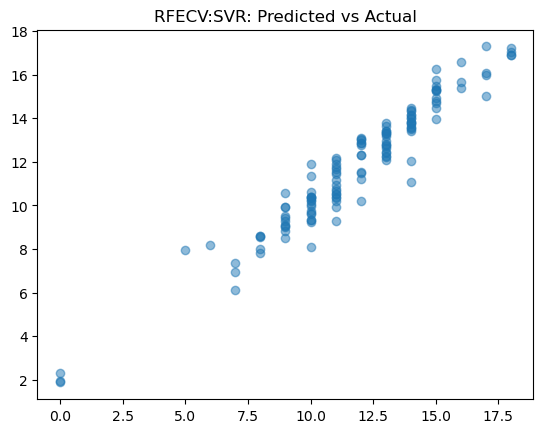




Testing Model Name: **RandomForestRegressor** with features: RFECV
Fitting 10 folds for each of 49 candidates, totalling 490 fits
Best n_estimators: 100 and Best max_depth: 4
The delta between the two MSE is: 23.77% 
r-squared for the test data: 0.913
r-squared for the train data: 0.887


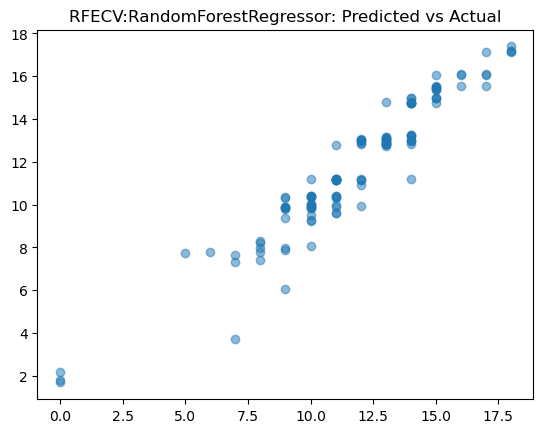

In [16]:
"""
Performs grid search with cross-validation on a set of models and hyperparameters, where the features themselves are
also hyperparameters.

The models can be either classifiers or regressors, and the hyperparameters to be tuned
depend on the type of model. The function outputs a table with the best hyperparameters and performance metrics for
each model and feature set, as well as a confusion matrix for each classifier. 


Key inputs to the function are:
- feature_selected: a dictionary where each key is a string representing a set of selected features, and each value
    is a list of strings representing the names of the selected features.  
- X_transformed: a pandas DataFrame containing the preprocessed feature data.
- Y: a pandas Series containing the target variable data.
- Y_labels: a list of strings representing the labels of the target variable classes (for classifiers only).
- use_categorical_classifier: a boolean indicating whether to use a classifier or a regressor for the models.
"""

if( use_categorical_classifier):
    output_table = pd.DataFrame(columns=['Model', 'H1', 'H2', 'Dataset', 'Features', 'Accuracy'])
else:
    output_table = pd.DataFrame(columns=['Model', 'H1', 'H2', 'Dataset', 'Features', 'MSE', 'R2'])


#
# Hyperparameters for each model
#

params_dict  = { "SVC" : {'kernel':['linear', 'rbf', 'sigmoid', 'poly'], 'C':[1, 2, 5, 10, 12, 14, 16, 18, 20, 25, 30, 35 ]},
                 "SVR" : {'kernel':['linear', 'rbf', 'sigmoid', 'poly'], 'C':[1, 2, 5, 10, 12, 14, 16, 18, 20, 25, 30, 35 ]},
                "RandomForestClassifier" : {'n_estimators':[10, 30, 50, 70, 90, 100,  120 ], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}, 
                "RandomForestRegressor" : {'n_estimators': [10, 30, 50, 70, 90, 100,  120 ], 'max_depth':[2, 3, 4, 5, 6, 7, 8]}}           


#
# Iterate through each feature set and model, and perform grid search with cross-validation
#

for key, feature_list in feature_selected.items():

    #
    # Generate the dataset
    #
    final_X = X_transformed[feature_list]
    final_categorical_features = final_X.select_dtypes(include=['object']).columns
    final_numerical_features = final_X.select_dtypes(include=['float64', 'int64','float32', 'int32']).columns

    X_train, X_test, y_train, y_test = train_test_split(final_X, Y, test_size=0.2, random_state=rand_state)

    preprocessor = ColumnTransformer(
                transformers=[
                ('num', MinMaxScaler(), final_numerical_features),
                ('cat', OrdinalEncoder(), final_categorical_features)])

    preprocessor.fit(final_X)

    X_train_transformed = preprocessor.transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)


    if( use_categorical_classifier ):
        svr = SVC(random_state=rand_state)
        rf = RandomForestClassifier(random_state=rand_state)
    else:
        svr = SVR()
        rf = RandomForestRegressor(random_state=rand_state)

    models = [svr, rf]

    for model in models:
        print(f"Testing Model Name: **{model.__class__.__name__}** with features: {key}")
            
        parameters = params_dict[model.__class__.__name__]  

        grid_search = GridSearchCV(model, param_grid = parameters, cv = 10, verbose=True, n_jobs=-1)

        final_clf = grid_search.fit(X_train_transformed, y_train)

        selected_model = None
        model_name = model.__class__.__name__
        h1 = pd.NA
        h2 = pd.NA

        if( model_name == "SVC" or model_name == "SVR" ):
            best_c = final_clf.best_estimator_.get_params()['C']
            best_kernel = final_clf.best_estimator_.get_params()['kernel']

            h1 = best_c
            h2 = best_kernel

            print(f"Best C: {best_c} and Best Kernel: {best_kernel}")
            #print(best_c, best_kernel)

            if( use_categorical_classifier ):
                selected_model = SVC(kernel=best_kernel, gamma='auto', C=best_c, random_state=rand_state)
            else:
                selected_model = SVR(kernel=best_kernel, gamma='auto', C=best_c)

        else:
            best_n_estimators = final_clf.best_estimator_.get_params()['n_estimators']
            best_max_depth = final_clf.best_estimator_.get_params()['max_depth']

            print(f"Best n_estimators: {best_n_estimators} and Best max_depth: {best_max_depth}")
            h1 = best_n_estimators
            h2 = best_max_depth
            
            #print(best_n_estimators, best_max_depth)

            if( use_categorical_classifier ):
                selected_model = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth)
            else:
                selected_model = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth)


        selected_model.fit(X_train_transformed, y_train)

        y_train_pred = selected_model.predict(X_train_transformed)
        y_test_pred = selected_model.predict(X_test_transformed)

        if( use_categorical_classifier ):
            display(f"Accuracy score for the training data: {accuracy_score(y_train, y_train_pred):.3f}")
            display(f"Accuracy score for the test data: {accuracy_score(y_test, y_test_pred):.3f}")

            cm_test = confusion_matrix(y_test, y_test_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=Y_labels)
            disp.plot()
            disp.ax_.set_title(f"{key}:{model_name}: Test Matrix")

            cm_train = confusion_matrix(y_train, y_train_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=Y_labels)
            disp.plot()
            disp.ax_.set_title(f"{key}:{model_name}: Train Matrix")


            output_table = output_table.append({'Model': model_name, 'H1' : h1, 'H2' : h2,  'Dataset': 'Test', 'Features': key, 'Accuracy': accuracy_score(y_test, y_test_pred)}, ignore_index=True)
            output_table = output_table.append({'Model': model_name, 'H1' : h1, 'H2' : h2, 'Dataset': 'Train', 'Features': key, 'Accuracy': accuracy_score(y_train, y_train_pred)}, ignore_index=True)
     

        else:
            mse_test = mean_squared_error(y_test, y_test_pred)
            mse_train = mean_squared_error(y_train, y_train_pred)

            percent_error = np.abs(mse_train - mse_test)/mse_train

            print(f"The delta between the two MSE is: {percent_error:.2%} ")
            print(f"r-squared for the test data: {r2_score(y_test, y_test_pred):.3f}")
            print(f"r-squared for the train data: {r2_score(y_train, y_train_pred):.3f}")


            output_table = output_table.append({'Model': model_name, 'H1' : h1, 'H2' : h2, 'Dataset': 'Test', 'Features': key, 'MSE': mse_test, 'R2': r2_score(y_test, y_test_pred)}, ignore_index=True)
            output_table = output_table.append({'Model': model_name, 'H1' : h1, 'H2' : h2, 'Dataset': 'Train', 'Features': key, 'MSE': mse_train, 'R2': r2_score(y_train, y_train_pred)}, ignore_index=True)

            #model_grade = selected_model.predict(preprocessor.transform(final_X))
            # Plot y_test as x and y_test_pred as y.   Please include model_name and key in chart title.
            plt.scatter(y_test, y_test_pred, alpha=0.5)
            plt.title(f"{key}:{model_name}: Predicted vs Actual")
            plt.show()


        print("\n\n")



In [ ]:
"""
Outputs the results on train & test for the various experiements

"""

sort_value = 'Accuracy' if use_categorical_classifier else 'R2'
output_table_test = output_table.query('Dataset == "Test"').sort_values(by=[sort_value], ascending=False)
output_table_train = output_table.query('Dataset == "Train"').sort_values(by=[sort_value], ascending=False)

output_table.sort_values(by=[sort_value], ascending=False)


In [18]:
"""
Outputs the results on train for the various experiements

"""

best_ac =  output_table_train[ sort_value ].max()
feature_set = output_table_train[ output_table_train[ sort_value ] == best_ac ][ 'Features' ].values[0]
best_features = feature_selected[ feature_set ]
unused_features = [ f for f in X_transformed.columns if f not in best_features ]



display(output_table_train.head(10))

print( f"Best features: {feature_set} {len(best_features)} : {best_features}")
print( f"Unused features: {len(unused_features)} : {unused_features}")





,Model,H1,H2,Dataset,Features,MSE,R2
11,RandomForestRegressor,70,5,Train,RFE,0.857063,0.918790
15,RandomForestRegressor,100,4,Train,RFECV,1.183357,0.886681
7,RandomForestRegressor,30,4,Train,LSV_SFM,1.183108,0.886074
3,RandomForestRegressor,30,4,Train,RF_SFM,1.541780,0.857641
5,SVR,30,linear,Train,LSV_SFM,1.680122,0.838215
13,SVR,20,linear,Train,RFECV,1.821526,0.825570
1,SVR,14,linear,Train,RF_SFM,1.915266,0.823155
9,SVR,35,linear,Train,RFE,1.883914,0.821492


Best features: RFE 16 : ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__Mjob', 'cat__famsup']
Unused features: 16 : ['num__studytime', 'num__failures', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Pstatus', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__paid', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']


In [19]:
"""
Outputs the results on TEST for the various experiements

"""
best_ac =  output_table_test[ sort_value ].max()
feature_set = output_table_test[ output_table_test[ sort_value ] == best_ac ][ 'Features' ].values[0]
best_features = feature_selected[ feature_set ]

display(output_table_test.head(10))

unused_features = [ f for f in X_transformed.columns if f not in best_features ]



print( f"Best features: {feature_set} {len(best_features)} : {best_features}")
print( f"Unused features: {len(unused_features)} : {unused_features}")




,Model,H1,H2,Dataset,Features,MSE,R2
2,RandomForestRegressor,30,4,Test,RF_SFM,0.600043,0.930354
8,SVR,35,linear,Test,RFE,0.722341,0.926864
12,SVR,20,linear,Test,RFECV,0.763673,0.925989
14,RandomForestRegressor,100,4,Test,RFECV,0.902124,0.912571
0,SVR,14,linear,Test,RF_SFM,0.776291,0.909897
10,RandomForestRegressor,70,5,Test,RFE,1.115955,0.887011
4,SVR,30,linear,Test,LSV_SFM,1.377185,0.869451
6,RandomForestRegressor,30,4,Test,LSV_SFM,1.820814,0.827397


Best features: RF_SFM 2 : ['num__absences', 'num__G2']
Unused features: 30 : ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__G1', 'cat__school', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Pstatus', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__famsup', 'cat__paid', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']


***

# RESULTS SECTION

## Classification

## Regregression


***



# Classification Results :


## Feature Selection


RF_SFM 3 ['num__failures', 'num__G1', 'num__G2']

LSV_SFM 12 ['num__studytime', 'num__failures', 'num__Dalc', 'num__Walc', 'num__health', 'num__G1', 'num__G2', 'cat__school', 'cat__famsize', 'cat__Pstatus', 'cat__schoolsup', 'cat__higher']

RFE 16 ['num__age', 'num__Medu', 'num__Fedu', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__Mjob', 'cat__reason']

RFECV 23 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__address', 'cat__famsize', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__higher']

## Train Results

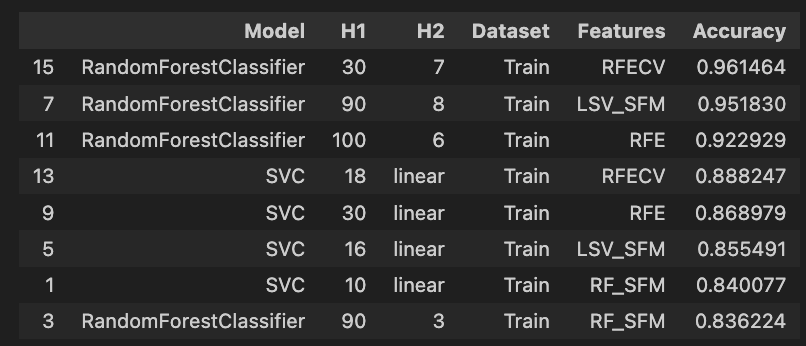


## Test  Results


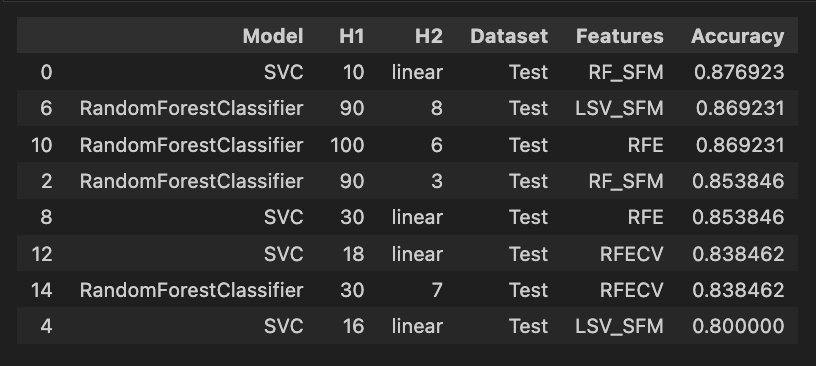

## Impact of removing G1 & G2 from X

#### Feature selection


RF_SFM 15 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__Mjob', 'cat__reason']

LSV_SFM 13 ['num__Medu', 'num__studytime', 'num__failures', 'num__famrel', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__school', 'cat__famsize', 'cat__Pstatus', 'cat__schoolsup', 'cat__higher']

RFE 15 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__Mjob', 'cat__reason']

RFECV 29 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__school', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Pstatus', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__famsup', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']

#### Train (excl G1/G2)

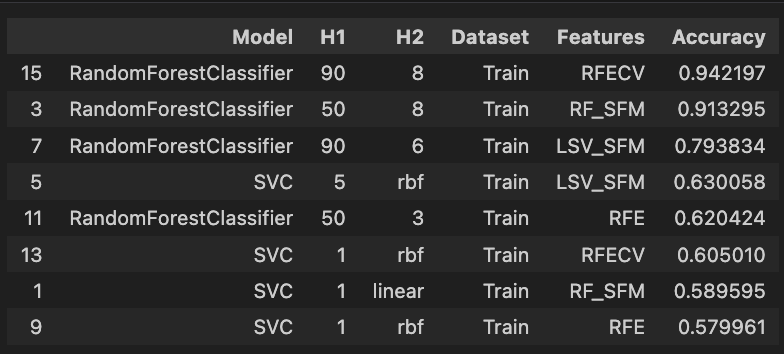

#### Test (excl G1/G2)

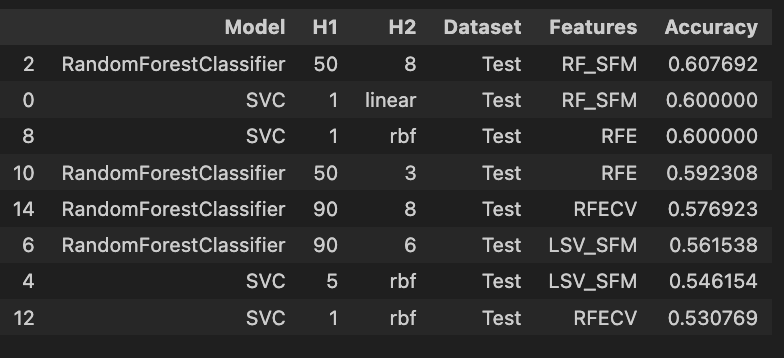

### Discussion



***

***

***

***

***



# Regression Results :

## Feature Selection

RF_SFM 2 ['num__absences', 'num__G2']

LSV_SFM 9 ['num__Fedu', 'num__studytime', 'num__failures', 'num__famrel', 'num__G1', 'num__G2', 'cat__address', 'cat__Pstatus', 'cat__higher']

RFE 16 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__Mjob', 'cat__famsup']

RFECV 31 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'num__G1', 'num__G2', 'cat__school', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__famsup', 'cat__paid', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']

## Train Results (including G1&G2)
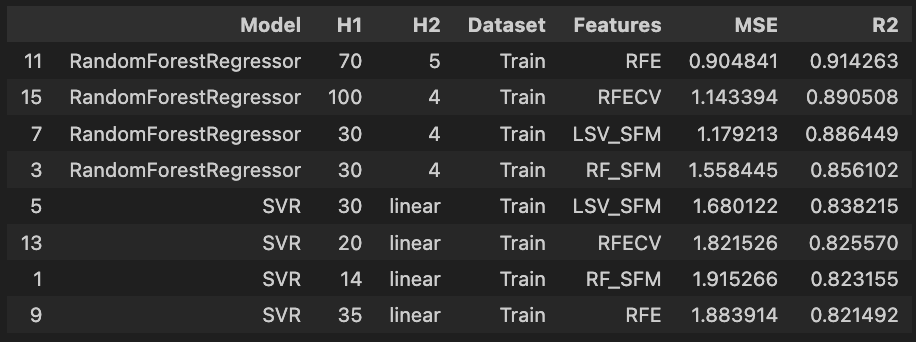

## Test  Results (including G1&G2)
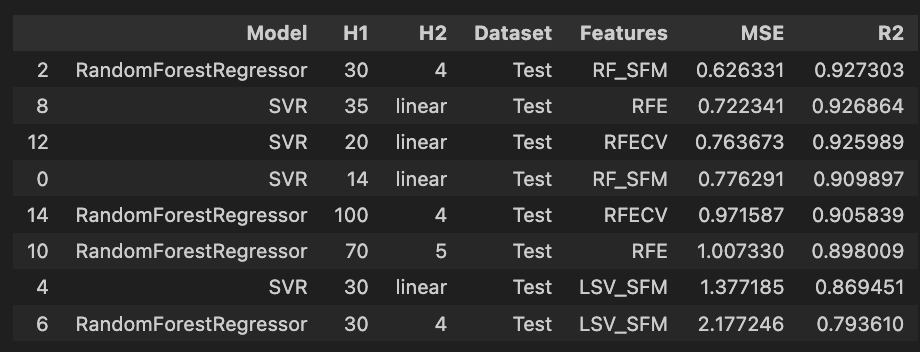

## Impact of removing G1 and G2 from X

#### Features selected

RF_SFM 13 ['num__Medu', 'num__Fedu', 'num__studytime', 'num__failures', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__school', 'cat__reason', 'cat__higher']

LSV_SFM 11 ['num__Medu', 'num__Fedu', 'num__studytime', 'num__failures', 'num__famrel', 'num__Dalc', 'cat__address', 'cat__Pstatus', 'cat__Fjob', 'cat__nursery', 'cat__higher']

RFE 15 ['num__age', 'num__Medu', 'num__Fedu', 'num__studytime', 'num__failures', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__school', 'cat__Mjob', 'cat__reason', 'cat__higher']

RFECV 29 ['num__age', 'num__Medu', 'num__Fedu', 'num__traveltime', 'num__studytime', 'num__failures', 'num__famrel', 'num__freetime', 'num__goout', 'num__Dalc', 'num__Walc', 'num__health', 'num__absences', 'cat__school', 'cat__sex', 'cat__address', 'cat__famsize', 'cat__Pstatus', 'cat__Mjob', 'cat__Fjob', 'cat__reason', 'cat__guardian', 'cat__schoolsup', 'cat__famsup', 'cat__activities', 'cat__nursery', 'cat__higher', 'cat__internet', 'cat__romantic']

#### Train(exl G1/G2)

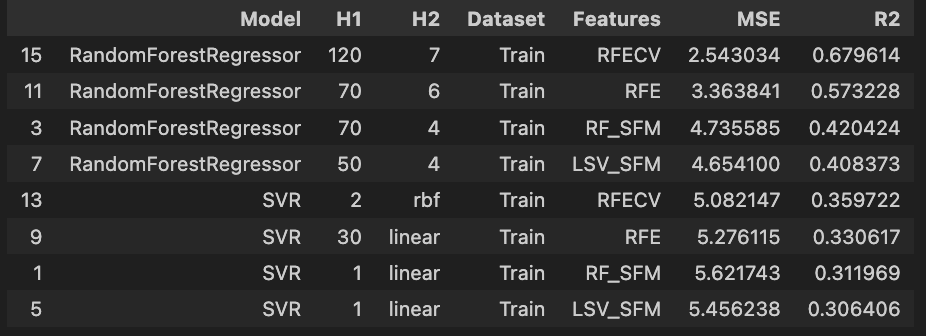

#### Test (exl G1/G2)

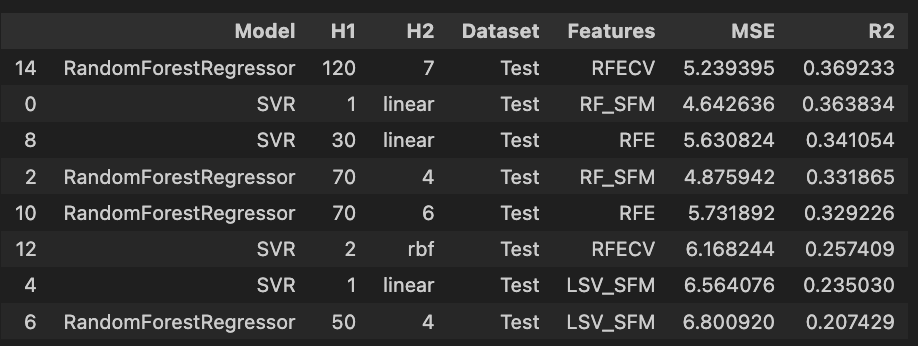

### Discussion
